## 2024机器智能 实验三

In [1]:
# File: 2024机器智能实验03_teacher.ipynb
# License: MIT License 
# Copyright: (c) 2024 Rongxi Li <lirx67@mail2.sysu.edu.cn> 
# Created: 2024-03-10
# Brief: 2024机器智能实验课教师版——实验三

### 必要依赖

In [2]:
!pip install --upgrade ipympl
!pip install numpy 
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
%matplotlib ipympl

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### 遗传算法

**绘图，不用看**

In [5]:
def plot_fitn(fitn_list, num=None):
    """绘制适应度变化图

    Args:
        his_fitn_list (list): 适应度历史列表
    """
    fig, ax = plt.subplots(num=num)
    ax.plot(fitn_list)
    ax.set_title("fitn")
    plt.show()

**遗传算法主要组成部分**

In [6]:
def ctrbp(nind, dim, lind):
    """创建种群

    Args:
        nind (int): 种群规模
        dim (int): 染色体维度
        lind (int): 染色体长度

    Returns:
        numpy.ndarray: 种群，三维数组，[nind, dim, lind]
    """
    return np.random.randint(2, size=(nind, dim, lind))

In [7]:
def recombin(chrom, rec_opt):
    """染色体交叉重组，两点交叉算子

    Args:
        chrom (numpy.ndarray): 种群，三维数组，[nind, dim, lind]
        rec_opt (float): 交叉概率，0-1

    Returns:
        numpy.ndarray: 交叉后的种群，三维数组，[nind, dim, lind]
    """
    nind, dim, lind = chrom.shape
    rand_nind = np.arange(nind)[None, :].repeat(dim, axis=0)
    for i in range(dim):
        np.random.shuffle(rand_nind[i, :])
    rand_nind_m = rand_nind[:, : nind // 2]
    rand_nind_w = rand_nind[:, nind // 2 : nind // 2 * 2 + 1]
    c_point_0 = np.random.randint(0, lind + 1, size=(dim, nind // 2))
    c_point_1 = np.random.randint(0, lind + 1, size=(dim, nind // 2))

    for i in range(dim):
        for j in range(nind // 2):
            if np.random.random() > rec_opt:
                break
            c_point_low = min(c_point_0[i, j], c_point_1[i, j])
            c_point_up = max(c_point_0[i, j], c_point_1[i, j])
            temp = chrom[rand_nind_m[i, j], i, c_point_low:c_point_up]
            chrom[rand_nind_m[i, j], i, c_point_low:c_point_up] = chrom[
                rand_nind_w[i, j], i, c_point_low:c_point_up
            ]
            chrom[rand_nind_w[i, j], i, c_point_low:c_point_up] = temp
    assert (chrom.shape == (nind, dim, lind), "chrom shape error")
    return chrom

<>:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\508225298.py:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (chrom.shape == (nind, dim, lind), "chrom shape error")


In [8]:
def mut(chrom, pm):
    """染色体变异

    Args:
        chrom (numpy.ndarray): 种群，三维数组，[nind, dim, lind]
        pm (float): 变异概率，0-1

    Returns:
        numpy.ndarray: 变异后的种群，三维数组，[nind, dim, lind]
    """
    nind, dim, lind = chrom.shape
    rand_mut = np.random.random(size=(chrom.shape)) < pm
    chrom[rand_mut] = 1 - chrom[rand_mut]
    assert(chrom.shape == (nind, dim, lind), "chrom shape error")
    return chrom

<>:14: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:14: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\1260015371.py:14: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(chrom.shape == (nind, dim, lind), "chrom shape error")


In [9]:
def select(chrom, fitn_v):
    """种群选择，轮盘赌法

    Args:
        chrom (numpy.ndarray): 种群，三维数组，[nind, dim, lind]
        fitn_v (numpy.ndarray): 适应度值，一维数组，[nind]

    Returns:
        numpy.ndarray: 选择后的种群，三维数组，[nind, dim, lind]
    """
    nind, dim, lind = chrom.shape
    fitness = fitn_v - fitn_v.max() - 1e-6
    select_idx = np.array(
        [np.random.choice(nind, p=fitness / fitness.sum()) for _ in range(nind * dim)]
    )
    select_idx = np.reshape(select_idx, (nind, dim))
    new_chrom = np.array(
        [chrom[:, i, :][select_idx[:, i]] for i in range(dim)]
    ).transpose(1, 0, 2)
    assert (chrom.shape == (nind, dim, lind), "chrom shape error")
    return new_chrom

<>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\609783959.py:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (chrom.shape == (nind, dim, lind), "chrom shape error")


In [10]:
def get_dec(chrom):
    """二进制染色体转换为十进制

    Args:
        chrom (numpy.ndarray): 种群，三维数组，[nind, dim, lind]

    Returns:
        numpy.ndarray: 十进制数值，二维数组，[nind, dim]
    """
    nind, dim, lind = chrom.shape
    binary_array = np.expand_dims(np.array([2**i for i in range(lind)]), 0)
    binary_array = np.repeat(binary_array, repeats=dim * nind, axis=0)
    binary_array = np.reshape(binary_array, (nind, dim, lind))
    ret = np.sum(chrom * binary_array, axis=2)
    return ret

In [11]:
def get_decoder(boundary):
    """获取解码函数

    Args:
        boundary (numpy.ndarray): 各维度的边界。
                二维数组，[dim, 2]，
                当输入一维数组时将自动扩展，此时各维度的边界相同。

    Returns:
        FunctionType: 解码函数
    """
    assert(len(boundary.shape) in [1, 2], "boundary shape error")
    def _inner(data, lind):
        """解码函数

        Args:
            data (numpy.ndarray): 待解码十进制数据，二维数组，[nind, dim]
            lind (int): 染色体长度

        Returns:
            numpy.ndarray: 解码后数据，二维数组，[nind, dim]
        """
        assert(len(data.shape) == 2, "data shape error")
        nonlocal boundary
        if len(boundary.shape) == 1:
            boundary = np.repeat(
                np.expand_dims(boundary, 0), repeats=data.shape[1], axis=0
            )
        ret = data.transpose(1, 0) / 2**lind * (
            np.expand_dims(boundary[:, 1], -1) - np.expand_dims(boundary[:, 0], -1)
        ) + np.expand_dims(boundary[:, 0], -1)
        return ret.transpose(1, 0)

    return _inner

<>:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\411230509.py:12: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(boundary.shape) in [1, 2], "boundary shape error")
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\411230509.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(data.shape) == 2, "data shape error")


#### 3.1 遗传算法流程

请使用以上给定的遗传算法主要组成部分，完成遗传算法的主要流程。

本文使用了轮盘赌选择法；多点交叉算子；基本位变异法。学有余力者实现其他的选择、交叉、变异算法，如：

选择：排序选择法、两两竞争法

交叉：单点交叉算子、多点交叉算子、均匀交叉算子

编译：均匀变异、边界变异、倒位变异

In [12]:
def ga(nind, dim, lind, rec_opt, pm, max_iter, e, decode, get_fitn):
    """遗传算法

    Args:
        nind (int): 种群规模
        dim (int): 染色体维度
        lind (int): 染色体长度
        rec_opt (float): 交叉概率
        pm (float): 变异概率
        max_iter (int): 最大迭代次数
        e (float): 收敛误差
        decode (FunctionType): 解码函数
        get_fitn (FunctionType): 适应度函数

    Returns:
        numpy.ndarray: 最优解，一维数组，[dim]
        List: 每次迭代的最佳或平均适应度，[float]
    """
    # 创建种群
    # ...
    his_fitn_list = []
    ret = None

    for iter in range(max_iter):
        # 计算适应度与最优解
        # ...
        
        # 判断是否收敛
        # ...

        # 选择、交叉、变异
        # ...
        pass

    return ret, his_fitn_list

In [13]:
## 答案
def ga(nind, dim, lind, rec_opt, pm, max_iter, e, decode, get_fitn):
    """遗传算法

    Args:
        nind (int): 种群规模
        dim (int): 染色体维度
        lind (int): 染色体长度
        rec_opt (float): 交叉概率
        pm (float): 变异概率
        max_iter (int): 最大迭代次数
        e (float): 收敛误差
        decode (FunctionType): 解码函数
        get_fitn (FunctionType): 适应度函数

    Returns:
        numpy.ndarray: 最优解，一维数组，[dim]
        List: 每次迭代的适应度，[float]
    """
    chrom = ctrbp(nind, dim, lind)
    his_fitn_list = [float("inf")]
    ret = None

    for iter in range(max_iter):
        data = get_dec(chrom)
        data = decode(data, lind)
        fitn_v = get_fitn(data)
        chrom_fitn = np.mean(fitn_v)
        best_idx = np.argmin(fitn_v)
        ret = data[best_idx, :]
        if abs(his_fitn_list[-1] - chrom_fitn) < e:
            break
        his_fitn_list.append(chrom_fitn)

        chrom = select(chrom, fitn_v)
        chrom = recombin(chrom, rec_opt)
        chrom = mut(chrom, pm)

    return ret, his_fitn_list[1:]

**适应度函数**

以下适应度函数用于求解$\min f(x)=x^2$

In [14]:
def get_fitn_demo(data):
    """适应度函数示例

    Args:
        data (numpy.ndarray): 解码后数据，二维数组，[nind, dim]

    Returns:
        numpy.ndarray: 适应度值，一维数组，[nind,]
    """    
    ret = data[:, 0] ** 2
    
    assert(ret.shape == (data.shape[0],), "fitn shape error")
    return ret

<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\jungh\AppData\Local\Temp\ipykernel_3692\3006707732.py:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(ret.shape == (data.shape[0],), "fitn shape error")


value: [-0.0078125]
iter: 55
fitn: 0.00013427734375


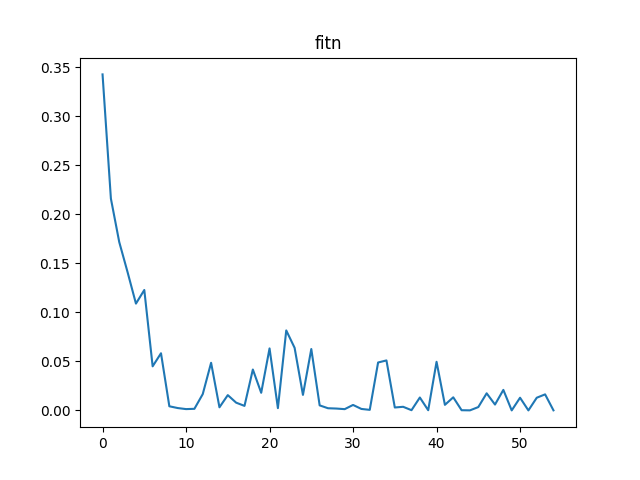

In [15]:
ret, fitn = ga(20, 1, 8, 0.8, 0.01, 100, 1e-4, get_decoder(np.array([-1, 1])), get_fitn_demo)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)

#### 3.2 极值搜索

##### 3.2.1 请通过遗传算法求解以下极小值与极大值

$f(x,y) = 3(1-x)^2\exp{[-x^2-(y+1)^2]}-10(\frac{x}{5}-x^3-y^5)\exp{(-x^2-y^2)}-\frac{1}{3}\exp{[-(x+1)^2-y^2]}$

其中：

$-2.048 \le x,y \le 2.048$

参考答案(近似值):

$x=0.26 \\ y=-1.61$

##### 2.2.2 通过遗传算法求解以下极值问题

$\min{f(x)=100(x^2-y)^2+(1-x)^2}$

1. 无约束情况时求解
   
   参考答案：$x=1,\; y=1$

2. 存在以下两个非线性约束条件和限制条件时求解
   
   $\begin{cases} xy+x-y+1.5\le0\\10-xy\le0\\0\le x\le1\\0\le y\le13 \end{cases}$

   参考答案：$x=0.8122,\; y=12.3122$


In [16]:
def get_fitn_t11(data):
    x = data[:, 0]
    y = data[:, 1]
    return (
        3 * (1 - x) ** 2 * np.exp(-(x**2) - (y + 1) ** 2)
        - 10 * (x / 5 - x**3 - y**5) * np.exp(-(x**2) - y**2)
        - 1 / 3 * np.exp(-((x + 1) ** 2) - y**2)
    )

value: [-1.323625  0.211375]
iter: 203
fitn: -2.772950561224896


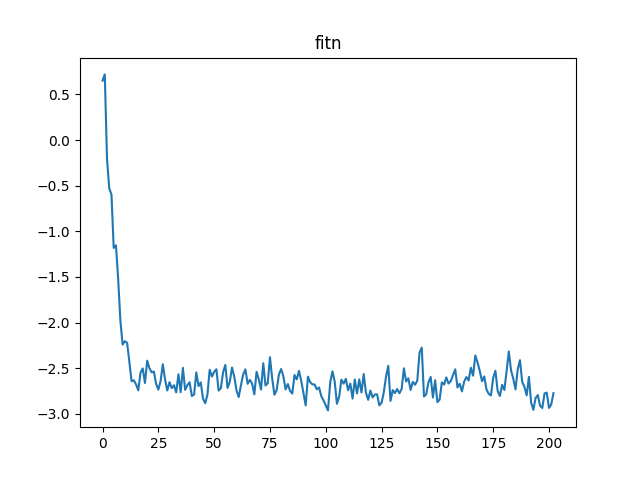

In [17]:
ret, fitn = ga(
    50,
    2,
    16,
    0.8,
    0.01,
    1000,
    1e-3,
    get_decoder(np.array([-2.048, 2.048])),
    get_fitn_t11,
)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)

In [18]:
def get_fitn_t12(data):
    x = data[:, 0]
    y = data[:, 1]
    return (
        -3 * (1 - x) ** 2 * np.exp(-(x**2) - (y + 1) ** 2)
        - 10 * (x / 5 - x**3 - y**5) * np.exp(-(x**2) - y**2)
        - 1 / 3 * np.exp(-((x + 1) ** 2) - y**2)
    )

value: [-0.2835625 -1.43175  ]
iter: 40
fitn: -10.004797703174106


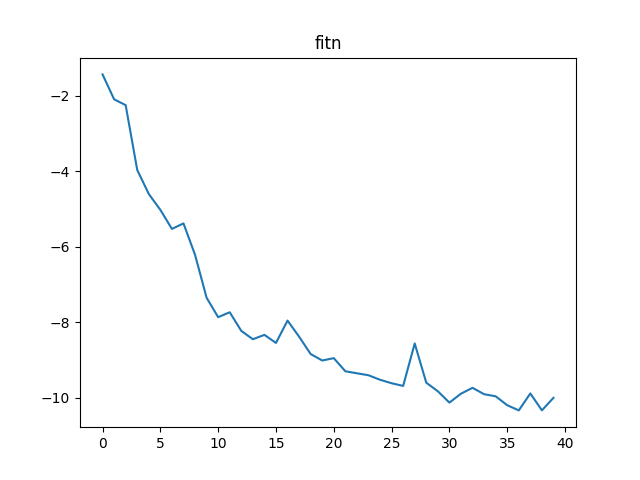

In [19]:
ret, fitn = ga(
    50,
    2,
    16,
    0.8,
    0.01,
    1000,
    1e-2,
    get_decoder(np.array([-2.048, 2.048])),
    get_fitn_t12,
)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)

In [20]:
def get_fitn_t21(data):
    x = data[:, 0]
    y = data[:, 1]
    return 100 * (x**2 - y) ** 2 + (1 - x) ** 2

value: [0.87051392 0.76605225]
iter: 82
fitn: 0.04465531304020137


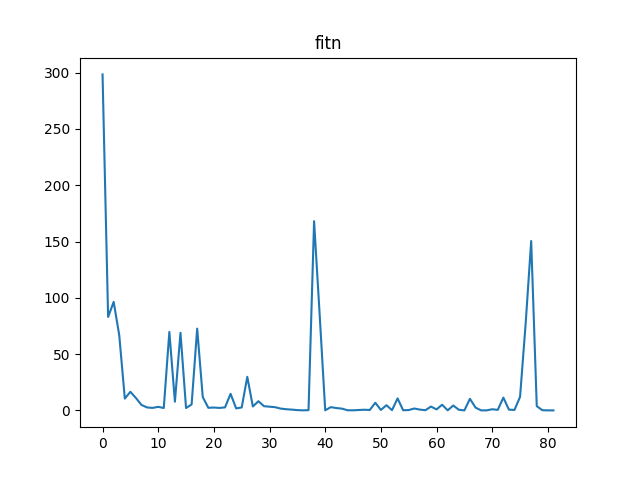

In [21]:
ret, fitn = ga(10, 2, 16, 0.6, 0.01, 10000, 1e-2, get_decoder(np.array([0, 2])), get_fitn_t21)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)

In [22]:
def get_fitn_t22(data):
    x = data[:, 0]
    y = data[:, 1]
    cons_0 = x * y + x - y + 1.5
    cons_1 = 10 - x * y
    cons_0[cons_0 < 0] = 0
    cons_1[cons_1 < 0] = 0
    return 100 * (x**2 - y) ** 2 + (1 - x) ** 2 + 1e4 * (cons_0**2 + cons_1)

value: [ 0.74949646 12.98750305]
iter: 74
fitn: 18896.85640077726


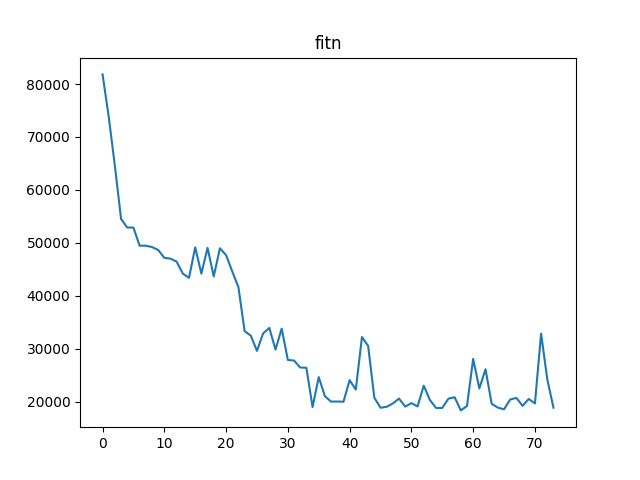

In [23]:
ret, fitn = ga(
    10,
    2,
    16,
    0.6,
    0.01,
    10000,
    0.5,
    get_decoder(np.array([[0, 1], [0, 13]])),
    get_fitn_t22,
)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)

#### 3.3 非线性函数拟合

假设有观测时间数据$x^*$和观测响应数据$y^*$，要求拟合以下形式的非线性函数模型，其中 a 和 b 为代求参数。

$y=ae^{bx}$

$
𝑥^∗=[0.9,1.5,13.8,19.8,24.1,28.2,35.2,60.3,74.6,81.3]$

$
𝑦^∗=[455.2,428.6,124.1,67.3,43.2,28.1,13.1,−0.4,−1.3,−1.5]
$


In [24]:
def get_fitn_t3(data):
    a = data[:, 0]
    b = data[:, 1]
    xs = np.array([0.9, 1.5, 13.8, 19.8, 24.1, 28.2, 35.2, 60.3, 74.6, 81.3])
    ys = np.array([455.2, 428.6, 124.1, 67.3, 43.2, 28.1, 13.1, -0.4, -1.3, -1.5])
    cost = 0
    for x, y in zip(xs, ys):
        cost += (a * np.exp(b * x) - y) ** 2
    return cost

value: [ 5.11136709e+02 -1.13285541e-01]
iter: 31
fitn: 1027.658034211445


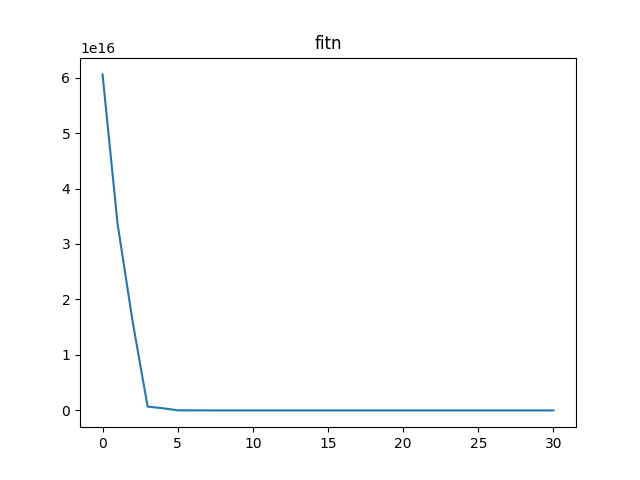

In [25]:
ret, fitn = ga(
    20,
    2,
    32,
    0.6,
    0.01,
    10000,
    100,
    get_decoder(np.array([[400, 600], [-0.2, 0.2]])),
    get_fitn_t3,
)
print(f"value: {ret}")
print(f"iter: {len(fitn)}")
print(f"fitn: {fitn[-1]}")
plot_fitn(fitn)